# **Chest X-ray Image Classification using Deep Learning**
### Classes: 
*   Normal
*   Pneumonia



# **Methodology: TO DO //**
Presented below is the implementation of the novel classifier using Deep Learning. The methodology of implementation is as follows: 
### *Step 1: Raw images*
> Dataset used: https://www.kaggle.com/muzin11/chest-xray-image - *"chest X-ray normal & pneumonia"* by Ji-Yul Kim.
- The dataset to be used has been downloaded and mounted to this notebook via Google Drive
- Raw images have been segmented into training, test and validation datasets to be fed to the Deep Neural Network Image classifier.

---

### *Step 2: Image Pre-processing*
> There are two forms of image pre-processing which have been utilised to transform images. These are: 
- Base Pre-processing: Where the image has been rescaled and converted to the float-32 format
- Additional Pre-processing: Where images have been adjusted using additional methods such as global centring (mean scaling) and Contrast Limited Adaptive Histogram Equilization (CLAHE)

---
### *Step 3: Neural Network training*
> One of the main limitations of working on the cloud, is the usage restrictions of GPU and the limited time for training the neural network. As a result, each model has been given a set of callbacks to follow which will stop model training when a particular criteria has been met. 

---

### *Step 5: Neural Network Testing*
> Each model has been tested using the test data provided by the dataset collated by Ji-Yul Kim (200 Normal frontal radiographs and 200 frontal radiographs containing Pneumonia characterisics).

---



## **Imported Libraries**
The below programming libraries were utilised due to their usefulness to the project implementation:

***Keras***
> One of the more popular AI programming libraries, Keras is a programming library, developed in Python and is capable of running on top of Tensorflow (another popular AI programming library). This programming library was mainly utilised for its capabilities of allowing the download, and use of transfer-learning based models. The majority of the coding elements relating to neural networks utilised the Keras library.

***Sklearn***

> SKlearn is a popular machine learning programming library, used for the classical classification, clustering and regression algorithms. This programing library was mainly used in order to obtain classification scores for each model produced.

***skimage***

> Skimage (sci-kit image) is a programming library which is mainly used for image pre-processing (computer vision tasks) in this case, this programming language has been used to convert images to the float format, and to utilise the CLAHE algorithm (from its 'exposure' module)

***Matplotlib (pyplot)***

> Among the most popular Pythonic programming languages, is Matplotlib (pyplot) this programming library is purposed with plotting data, which is useful when evaluating the performance of each model.

***Numpy***

> NumPy is a Pythonic programming language which is tasked with supporting large, multi-dimensional datatypes such as matrices and arrays. To complement this, it also contains a substantial collection of high-level mathematical algorithms which can be used to compute such algorithms on the aforementioned multi-dimensional datatypes. This would be very useful to the project, due to its mathematical capabilities on multi-dimensional data, especifally useful for operations which will be computed using image data (as image data is typically represented as a matrix). 

***Python OS***

> The Python OS library is an in-built library for python which allows for file I/O operations. This was mainly used to save and load models, as well as, implementing custom functions to create, delete and clear model directories.

***Google Colab***

> The Google colab programming language for Python was mainly utilised for accessing google drive, as most data was stored in Google Drive.





In [4]:
###### KERAS IMPORTS ######
from keras.layers import Input, Dense, Flatten, Dropout,  MaxPooling2D, AveragePooling2D, Conv2D, BatchNormalization, Activation 
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau 
from keras.models import Model, load_model 
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.applications import InceptionV3
from keras.optimizers import Adam, SGD
from keras import layers
###### SKLEARN IMPORTS ######
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
###### SKIMAGE IMPORTS ######
from skimage import img_as_float, exposure
###### GOOGLE DRIVE IMPORT ######
from google.colab import drive
#################################
from termcolor import colored # This import was utilised to colour the text when an image has been incorrectly classified
###### MATPLOTLIB IMPORT ######
import matplotlib.pyplot as plt
import pandas as pd # Pandas was imported for the saving and loading of models as a pandas DataFrame
import numpy as np # Importing Numpy for use in mathematical computations
import itertools # Itertools was imported to give the ability to search through ImageDataGenerator batch data
import shutil # shutil was utilised to delete directories and their contents when required
import time  
import csv
import os 

# Mount drive for access to the dataset
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## **Establishing Paths for File Operations**




In [2]:
root_path = "/content/gdrive/My Drive/Colab Notebooks/Chest_X_Ray_Dataset/"
train_path = root_path + "train/"
test_path = root_path + "test/"
val_path = root_path + "val/"
csv_directory = "/content/gdrive/My Drive/Colab Notebooks/logs/"

## **Helper methods for file operations**

In [3]:
def get_file_count(directory):
  """
    The get_file_count method has been utilised mainly as a helper method to the get_class_weights method it returns the total number of files in the given directory
  """
  return sum([len(files) for root, dirs, files in os.walk(directory)])

# For models specifically:

def get_file_paths(path):
  """
    The get_file_paths method is mainly used as a helper method for removing files from the desired filepath
      Input: the path of the desried model
      Output: An array containing the filenames of each file within the model directory
  """
  filepaths = []
  for r, d, files in os.walk(path):
    for file in files: 
      filepaths.append(path + str(file))
  return filepaths

def get_model_directory(model_num, mode="max"):
  """
    The get_model_directory is a helper method which is used by most of the other assistive methods utilised. 
    It's aim is to return the desired model's directory
      Input: The model number and the pooling strategy (denoted by mode)
      Output: The directory of the desired model
  """
  if mode=="max": 
    return "/content/gdrive/My Drive/Colab Notebooks/Models/Max Pooling Strategy/Model " + str(model_num) + "/"
  else: 
    return "/content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model " + str(model_num) + "/"

def create_model_directory(model_num, mode="max"): 
  """
    The create_model_directory is a helper method which has been designed to create the directory of the desired model if it does not already exist.
      Input: the model number and the pooling strategy (denoted by mode)
      Output: this method returns null but creates the directory of the desired model
  """
  dir_path = get_model_directory(model_num, mode) # get the desired model directory from the get_model _directory method
  if not os.path.exists(dir_path): # If the directory does not exist
    print("Path does not exist, creating directory at path: {}".format(dir_path)) # Print this message
    try: 
      os.mkdir(dir_path) # Create the directory
    except Exception as e: # If there is an issue, throw an exception and print it in the console (for debugging purposes)
      print(e)
  else: # Otherwise if the directory does in fact exist
    print("Path Exists already: {}".format(dir_path)) # Print this message

def clear_model_directory(model_num, mode="max"):
  """
    The clear_model_directory, is a helper methos which has been designed to clear the contents of a particular folder. This was created when adjustments to the overall architecture 
    were being made. This method was specifically designed to improve the organisation of the drive location, as well as free up space when necessary.
      Input: the model number and the pooling strategy (denoted by mode)
      Output: this method returns null but clears the desired directory without deleting the folder.
  """
  dir_path = get_model_directory(model_num, mode) # get the desired model directory from the get_model_directory method
  if os.path.exists(dir_path): # If the path exists
    print("Clearing all files at path: {}".format(dir_path)) # Print this messafe
    filepaths = get_file_paths(dir_path) # Get the filepaths contained within the directory
    for path in filepaths: # for each file path
      try: # try to remove the filepath 
        os.remove(path) # attempt to remove the filepath
        print("Removed file at path: {}".format(path)) # print this message if successful
      except Exception as e: # If there is an issue, throw an exception and print it in the output console (for debugging purposes)
        print(e)
  else: # Otherwise, if the filepath does not exist
    print("Path does not exist at path: {}".format(dir_path)) # Print this message

def delete_model_directory(model_num, mode="max"):
  """
    The delete_model_directory was created to delete a particular folder, as well as its contents when necessary to free-up storage space. This helper method was designed so that when
    adjustments to any model were made, they were retrained 'from scratch' meaning a new directory was created for this
      Input: the mdesired model number and the pooling strayegy (denoted by mode)
      Output: this method outputs null, however, it deletes the entire directory
  """
  dir_path = get_model_directory(model_num, mode) # get the desired model directory using the get_model_directory method
  if os.path.exists(dir_path): # If the path exists
    print("Deleting model directory and all of its files at path: {}".format(dir_path)) # Print this message
    try: # try to carry out the following
      shutil.rmtree(dir_path) # delete the directory as well as its contents
    except Exception as e: # If there is a problem, throw an exception and print it in the console (for debugging purposes)
      print(e)
  else: # Otherwise if the path does in fact exist
    print("Path Does not exist at path: {}".format(dir_path)) #print this message


## **Image Preprocessing and Augmentation**

In [7]:
def preprocess_image(image): 
    """
      the preprocess_image is a helper method which is used to apply additional pre-processing  to images which were used in models 2 and 3. 
        Input: The input image
        Output: the final image which has been normalised, globally centered, and equalised
    """
    image = img_to_array(image) / 255.0
    image = image - image.mean(axis=(0,1), dtype='float32')
    CLAHE_image = exposure.equalize_adapthist(image, clip_limit=2.0)
    return CLAHE_image

def get_img_datagen(model_num, batch_size, target_size, rescale_factor=1./255):
  """
    
      Input: 
      Output:
  """
  # ImageDataGenerator yields an iterable containing a batch of data with the shape (batch_size,width,height,channels). In this case, each batch yielded will be of the shape (32,224,224,3)
  # Using the ImageDataGenerator Class will help with memory constraints
  # Using the flow_from_directory method will automatically apply base pre-processing to images, returning batches of augmented/normalised data based on the rescale factor given (in the float-32 datatype)
  if model_num == 1: 
    # Model 1 uses only base preprocessing and image augmentation:
    train_generator = ImageDataGenerator(rescale = rescale_factor, shear_range=0.2, zoom_range=0.2, rotation_range=15, horizontal_flip=True)
    train_datagen = train_generator.flow_from_directory(directory=train_path, target_size=target_size, color_mode='rgb', batch_size=batch_size, class_mode='categorical', shuffle=True)

    test_generator = ImageDataGenerator()
    test_datagen = test_generator.flow_from_directory(directory=test_path, target_size=target_size, color_mode='rgb', batch_size=get_file_count(test_path), class_mode='categorical', shuffle=False)

    val_generator = ImageDataGenerator()
    val_datagen = val_generator.flow_from_directory(directory=val_path, target_size=target_size, color_mode='rgb', batch_size=get_file_count(test_path), class_mode='categorical', shuffle=False)
  else: 
    # models 2 and 3 models will use 
    train_generator = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=15, horizontal_flip=True, preprocessing_function=preprocess_image)
    train_datagen = train_generator.flow_from_directory(directory=train_path, target_size=target_size, color_mode='rgb', batch_size=batch_size, class_mode='categorical', shuffle=True)

    test_generator = ImageDataGenerator(preprocessing_function=preprocess_image)
    test_datagen = test_generator.flow_from_directory(directory=test_path, target_size=target_size, color_mode='rgb', batch_size=get_file_count(test_path), class_mode='categorical', shuffle=False)

    val_generator = ImageDataGenerator(preprocessing_function=preprocess_image)
    val_datagen = val_generator.flow_from_directory(directory=val_path, target_size=target_size, color_mode='rgb', batch_size=get_file_count(test_path), class_mode='categorical', shuffle=False)
  return train_datagen, test_datagen, val_datagen

batch_size=32
target_size = (224,224) # Images are intended to be resized to a constant size of 224px X 224px
rescale_factor = 1./255 # Images are intended to be normalised with 


## **Model Configuration**

**Model Creation**

In [8]:
def get_model(mode="max"):
  """
    The get_model method is a helper method, used to build the neural network according to the proposed architecture. It takes an input of "mode" which is the pooling strategy to be utilised
    The output of this model should be the same architecture with differing pooling strategies across all models
    Follows the architecture: 
      Stacked Convolution -> Batch Normalisation -> Activation -> Pooling -> Dropout
    
    Builds featuremaps with an increasing number of filters
  """
  model = Sequential()
  input_shape = target_size + (3,) # The input shape should match the tensor image data shape (224,224,3). As color mode is 'rgb', images will contain 3 channels, thus, adding (3,) to the target size will achieve this
  ###### Stacked convolution ######
  model.add(Conv2D(filters=32, kernel_size=(9,9), input_shape=input_shape))
  model.add(Conv2D(filters=32, kernel_size=(9,9), kernel_regularizer='l2', padding='same'))
  ###### Batch Normalisation ######
  model.add(BatchNormalization())
  ##### Layer Activation ######
  model.add(Activation('relu'))
  if mode == "max": # If the mode is "max"
    model.add(MaxPooling2D(pool_size=(2,2))) #Implement Max-pooling
  else: #Otherwise
    model.add(AveragePooling2D(pool_size=(2,2))) #Implement Average pooling
  model.add(Dropout(0.2)) # Adding dropout to the reduce the probability of the model overfitting

  ###### Stacked convolution ######
  model.add(Conv2D(filters=64, kernel_size=(9,9), padding='same'))
  model.add(Conv2D(filters=64, kernel_size=(9,9), kernel_regularizer='l2', padding='valid'))
  ###### Batch Normalisation ######
  model.add(BatchNormalization())
  ##### Layer Activation ######
  model.add(Activation('relu')) 
  if mode == "max": # If the mode is "max"
    model.add(MaxPooling2D(pool_size=(2,2))) #Implement Max-pooling
  else: #Otherwise
    model.add(AveragePooling2D(pool_size=(2,2))) #Implement Average pooling
  model.add(Dropout(0.25)) # Adding dropout to the reduce the probability of the model overfitting

  ###### Stacked convolution ######
  model.add(Conv2D(filters=96, kernel_size=(6,6), padding='same'))
  model.add(Conv2D(filters=96, kernel_size=(6,6), kernel_regularizer='l2', padding='valid'))
  ###### Batch Normalisation ######
  model.add(BatchNormalization())
  ##### Layer Activation ######
  model.add(Activation('relu')) 
  if mode == "max": # If the mode is "max"
    model.add(MaxPooling2D(pool_size=(2,2))) #Implement Max-pooling
  else: #Otherwise
    model.add(AveragePooling2D(pool_size=(2,2))) #Implement Average pooling
  model.add(Dropout(0.3)) # Adding dropout to the reduce the probability of the model overfitting

  ###### Stacked convolution ######
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), kernel_regularizer='l2', padding='valid'))
  ###### Batch Normalisation ######
  model.add(BatchNormalization())
  ##### Layer Activation ######
  model.add(Activation('relu')) 
  if mode == "max": # If the mode is "max"
    model.add(MaxPooling2D(pool_size=(2,2))) #Implement Max-pooling
  else: #Otherwise
    model.add(AveragePooling2D(pool_size=(2,2))) #Implement Average pooling
  model.add(Dropout(0.35)) # Adding dropout to the reduce the probability of the model overfitting

  ###### Stacked convolution ######
  model.add(Conv2D(filters=160, kernel_size=(3,3), padding='same'))
  model.add(Conv2D(filters=160, kernel_size=(3,3), kernel_regularizer='l2', padding='valid'))
  ###### Batch Normalisation ######
  model.add(BatchNormalization())
  ##### Layer Activation ######
  model.add(Activation('relu')) 
  if mode == "max": # If the mode is "max"
    model.add(MaxPooling2D(pool_size=(2,2))) #Implement Max-pooling
  else: #Otherwise
    model.add(AveragePooling2D(pool_size=(2,2))) #Implement Average pooling
  model.add(Dropout(0.4)) # Adding dropout to the reduce the probability of the model overfitting

  model.add(Flatten()) # Flattening the tensors
  # Passing the results to the first fully connected layer
  model.add(Dense(units=128, activation='relu')) # First Fully Connected Layer
  model.add(Dropout(0.5)) # Adding dropout to the reduce the probability of the model overfitting
  model.add(Dense(units=128, activation='relu'))# Second Fully Connected Layer
  model.add(Dropout(0.2)) # Adding dropout to the reduce the probability of the model overfitting
  model.add(Dense(2, activation='softmax')) # Implementing the auxiliary classifier (dense layer using the softmax activation function)
  return model

**Model Callbacks**

In [9]:
class CustomCallback(Callback):
  """
    In order to prevent the third model from overfitting, a custom model callback was utilised. This is used to stop the training when the model reaches
    the default value of 95.9% training accuracy
  """
  def __init__(self, threshold=0.959):
    super(CustomCallback, self).__init__()
    self.threshold=threshold

  def on_epoch_end(self, epoch, logs=None):
    current_accuracy = logs["accuracy"]
    if current_accuracy > self.threshold:
      print("Reached accuracy threshold on epoch: {}, training will terminate".format(epoch))
      self.model.stop_training = True

def create_log_directory(directory):
  """
    The create_log_directory has been implemented in the same way that the create_model_directory method has been implemented
  """
  try: # Try the following
    print("Creating Directory") # Print this statement
    os.mkdir(directory) # Create the directory
  except Exception as e: # If there is an issue, throw an exception and print it (for debugging putposes)
    print(e)

def get_callbacks(model_num, mode="max"):
  """
    The get_callbacks method is a helper method which was implemented to apply callbacks to a given model to abide by the constraints of Google Colab
    There are 5 callbacks used (4 for models 1 and 2, and 5 for model 3)
  """
  model_directory = get_model_directory(model_num, mode) # Get the model directory
  early_stop = EarlyStopping(monitor="val_loss", mode='min', patience=5, restore_best_weights=True, verbose=1) # Stop when the validation loss is at its minima and is unchanging
  best_checkpoint = ModelCheckpoint(filepath= model_directory + "{epoch:02d}-epochs-{val_accuracy:.3f}-val_acc-{val_loss:.3f}-val_loss.hdf5", monitor="val_accuracy", mode='max', save_best_only=True, verbose=1)  # If the validation accuracy is higher than in the previous epoch, save this as a checkpoint to load
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5) # When the validation loss is starting to plateu, wait for 3 epochs and reduce the learning rate
  if model_num == 3: # If obtaining callbacks for the third model
    print("Returning early_stop, best_checkpoint, reduce_lr and custom_callback") # include the custom callback when returning for model training
    custom_callback = CustomCallback(threshold=0.969) # increase the threshold to 96.9% in the callback (obtained from experimenting with this value)
    return [best_checkpoint, early_stop, reduce_lr, custom_callback]
  else: # Otherwise, use the default callbacks
    print("Returning_early stop, best_checkpoint and reduce_lr")
    return [best_checkpoint, early_stop, reduce_lr]

**Finding the path of the best model (Highest validation accuracy, Lowest validation loss)**

In [12]:
def get_best_model_name(dir):
  filelist = os.listdir(dir)
  print(filelist)
  best_index = len(filelist) - 1
  return dir + filelist[best_index]

**Best Model Result Retrieval**

In [14]:
def print_results(model_num, best_model):
  print("Evaluating Model " + str(model_num))
  evaluated_results = best_model.evaluate(test_datagen, verbose=1)
  loss = evaluated_results[0]
  accuracy = evaluated_results[1]
  print("Making predictions using Model " + str(model_num))
  predicted = best_model.predict(test_datagen, verbose=1)
  predicted = predicted.argmax(axis=-1)
  true = test_datagen.classes
  precision = precision_score(true, predicted) 
  recall = recall_score(true, predicted) 
  f1 = f1_score(true, predicted)
  auc_score = roc_auc_score(true, predicted)
  print('-'*35)
  print(" " * 5 + "Printing Model " + str(model_num) + " Results")
  print("-"*35)
  print(" -> Loss: {0:.2f}  ".format(loss))
  print(" -> Accuracy: {0:.2f}%".format(accuracy*100))
  print(" -> Precision: {0:.2f}%".format(precision*100))
  print(" -> Recall: {0:.2f}%".format(recall*100))
  print(" -> F1-Score: {0:.2f}%".format(f1*100))
  print(" -> AUROC-Score: {0:.4f}".format(auc_score))
  return true, predicted


**Plotting The Best Models Confusion Matrix**

In [15]:
def plot_conf_matrix(conf_matrix, classes, model_num):
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)
  plt.title(label="Model "+str(model_num)+" Confusion Matrix")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(ticks=tick_marks, labels=classes, rotation=45)
  plt.yticks(ticks=tick_marks, labels=classes)
  threshold = conf_matrix.max() / 2.
  for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
      plt.text(j, i, conf_matrix[i, j],
          horizontalalignment="center",
          color="white" if conf_matrix[i, j] > threshold else "black")
  plt.tight_layout()
  plt.ylabel('True Classes')
  plt.xlabel('Predicted Classes')

**Plotting Training and Validation Accuracy** 



In [16]:
def plot_accuracy(model_history, model_num, csv=False):
  if csv==True: 
    plots = model_history.plot.line(x='Epochs', y=['Accuracy', 'Validation_Accuracy'])
    plt.title(label="Model "+str(model_num)+" Accuracy")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs")
  else: 
    plt.figure()
    plt.title(label="Model "+str(model_num)+" Accuracy")
    plt.plot(np.arange(0, len(model_history.epoch)), model_history.history['accuracy'], label='train accuracy')
    plt.plot(np.arange(0, len(model_history.epoch)), model_history.history['val_accuracy'], label='validation accuracy')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs")
  plt.show()

def plot_loss(model_history, model_num, csv=False):
  if csv == True: 
    plots = model_history.plot.line(x='Epochs', y=['Training_Loss', 'Validation_Loss'])
    plt.title(label="Model "+str(model_num)+" Loss")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylabel("Loss")
    plt.xlabel("Number of Epochs")
  else:
    plt.figure()
    plt.title(label="Model "+str(model_num)+" Loss")
    plt.plot(np.arange(0, len(model_history.epoch)), model_history.history['loss'], label='train loss')
    plt.plot(np.arange(0, len(model_history.epoch)), model_history.history['val_loss'], label='validation loss')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylabel("Loss")
    plt.xlabel("Number of Epochs")
  plt.show()

**Loading the history of a particular model**

In [17]:
def load_df_from_csv(csv_directory):
  print("Available Files: ")
  count = 1
  for r, d, files in os.walk(csv_directory):
    for filename in files: 
      print("{}) {}".format(count, filename))
      count += 1
  i = input("Input File name: \n")
  file_path = csv_directory + i
  dataframe = pd.read_csv(file_path, sep=',', index_col=0)
  return dataframe

def modelHistory_tocsv(model_history, model_num, mode="max", overwrite=True):
  history_dict = {}
  time_string = time.strftime("%d-%m-%Y_(%H_%M)")
  csv_file = csv_directory + "Model_"+ str(model_num) + "_training_"+ str(time_string) +".csv"
  model_directory = get_model_directory(model_num, mode)
  history_dict["Epochs"] = model_history.epoch
  history_dict["Validation_Accuracy"] = model_history.history['val_accuracy']
  history_dict["Accuracy"] = model_history.history['accuracy']
  history_dict["Validation_Loss"] = model_history.history['val_loss']
  history_dict["Training_Loss"] = model_history.history['loss']
  model_dataFrame = pd.DataFrame(history_dict, columns=history_dict.keys(), index=history_dict["Epochs"])
  if overwrite==True: 
    if os.path.exists(csv_file):
      print("Overwriting file at path: {}".format(csv_file))
      model_dataFrame.to_csv(csv_file, sep=',')
    else:
      print("Path does not exist. Creating new directory at path: {}".format(csv_file))
      create_log_directory(csv_directory)
      model_dataFrame.to_csv(csv_file, sep=',')
  else: 
    print("Appending to current model csv at path {}".format(csv_file))
    csv_dataFrame = load_df_from_csv(csv_directory)
    csv_dataFrame.append(model_dataFrame, ignore_index=True)

In [ ]:
def get_class_weights(generator_classes):
  weight = class_weight.compute_class_weight('balanced', np.unique(generator_classes), generator_classes)
  weight = {w : weight[w] for w in range(len(weight))}
  return weight

In [ ]:
def get_image_filelist(path):
  filelist=[]
  for r, d, files in os.walk(path):
    for filename in files:
      filelist.append(r+"/"+filename)
  return filelist

def get_file_dict(batch_size):
  filedict = {} # Contains the name of the file as the key and the path to that file as the value
  random_indexes = np.random.randint(0, 400, size=[1,batch_size])[0]
  test_filelist = get_image_filelist(test_path)
  for index in random_indexes:
    filedict[test_filelist[index].split("/")[-1]] = test_filelist[index]
  return filedict, test_filelist, random_indexes

def display_prediction_samples(model_num, best_model, true, predicted, batch_size=10):
  """
  Load Images of size batch size
  reference the true value of the image
  reference the predicted value of the image
  display the heatmap of the image
  """
  filedict, filelist, indexes = get_file_dict(batch_size)
  print("displaying images")
  count = 0
  for path in filedict: 
    if path == filelist[indexes[count]].split("/")[-1]:
      original_image = cv2.imread(filedict[path])
      original_image = cv2.resize(original_image, (224,224))  
      print("Image"+str(count)+": "+path)
      if true[indexes[count]] == 0: 
        print("True: Normal")
      else: 
        print("True: Pneumonia")
      if predicted[indexes[count]] == 0 and true[indexes[count]] == 0: 
        print("Predicted: Normal")
      elif predicted[indexes[count]] == 1 and true[indexes[count]] == 1: 
        print("Predicted: Pneumonia")
      elif predicted[indexes[count]] == 1 and true[indexes[count]] == 0: 
        print(colored("Predicted: Pneumonia",'red')) 
      elif predicted[indexes[count]] == 0 and true[indexes[count]] == 1: 
        print(colored("Predicted: Normal",'red'))
      cv2_imshow(original_image)
    count += 1
    print("")

## **Model 1 (Max pooling strategy)**


**Model 1 Creation**


> **Using Max Pooling Strategy**




In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm (0.001)
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
"""
Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
 - The default value is 0.9 however, this value would be best configured with a decay rate of: 
    -> learning_rate(lr) / number of iterations (epochs) 
"""
model_1 = get_model()
model_1.compile(optimizer=optimizer_config, loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 216, 32)      7808      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      82976     
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 216, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      1

**Training Model 1**

In [ ]:
train_datagen, test_datagen, val_datagen = get_img_datagen(1, batch_size, target_size, rescale_factor)

Found 1870 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [ ]:
print("Training Model 1: ")
create_model_directory(1)
callbacks = get_callbacks(1)
model_1_history = model_1.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=num_epochs, validation_data=val_datagen, validation_steps=len(val_datagen), callbacks=callbacks)

Training Model 1: 
Path Exists already: /content/gdrive/My Drive/Colab Notebooks/Models/Model 1/
Returning_early stop, best_checkpoint and reduce_lr
Epoch 1/25
59/59 [==============================] - 64s 1s/step - loss: 4.4520 - accuracy: 0.6610 - val_loss: 2.5947 - val_accuracy: 0.5455

Epoch 00001: val_accuracy improved from -inf to 0.54545, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 1/01-epochs-0.545-val_acc-2.595-val_loss.hdf5
Epoch 2/25
59/59 [==============================] - 60s 1s/step - loss: 2.2689 - accuracy: 0.7936 - val_loss: 41.4108 - val_accuracy: 0.7555

Epoch 00002: val_accuracy improved from 0.54545 to 0.75545, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 1/02-epochs-0.755-val_acc-41.411-val_loss.hdf5
Epoch 3/25
59/59 [==============================] - 60s 1s/step - loss: 1.2222 - accuracy: 0.8241 - val_loss: 2184.2734 - val_accuracy: 0.4545

Epoch 00003: val_accuracy did not improve from 0.75545
Epoch 4/25
59/59 [=

**Testing the best version of Model 1**

In [ ]:
model_1_directory = get_model_directory(1, mode="max")
model_1_best_path = get_best_model_name(model_1_directory)
model_1_best = load_model(model_1_best_path)
true, predicted = print_results(1, model_1_best)

['.ipynb_checkpoints', '01-epochs-0.545-val_acc-2.595-val_loss.hdf5', '02-epochs-0.755-val_acc-41.411-val_loss.hdf5']
Evaluating Model 1
1/1 [==============================] - 0s 2ms/step - loss: 2.0888 - accuracy: 0.4725
Making predictions using Model 1
1/1 [==============================] - 1s 1s/step
-----------------------------------
     Printing Model 1 Results
-----------------------------------
 -> Loss: 2.09  
 -> Accuracy: 47.25%
 -> Precision: 47.92%
 -> Recall: 63.50%
 -> F1-Score: 54.62%
 -> AUROC-Score: 0.4725


displaying images
Image0: person44_virus_94.jpeg
True: Pneumonia
Predicted: Pneumonia


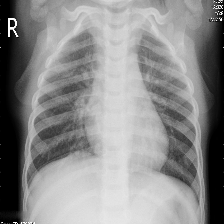


Image1: NORMAL2-IM-0222-0001.jpeg
True: Normal
Predicted: Pneumonia


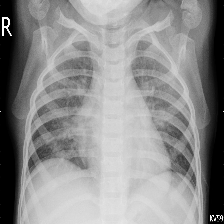


Image2: person85_bacteria_423.jpeg
True: Pneumonia
Predicted: Pneumonia


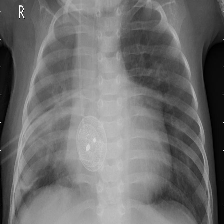


Image3: IM-0030-0001.jpeg
True: Normal
Predicted: Pneumonia


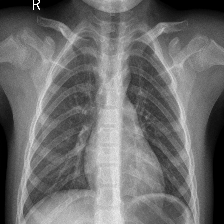


Image4: NORMAL2-IM-0336-0001.jpeg
True: Normal
Predicted: Normal


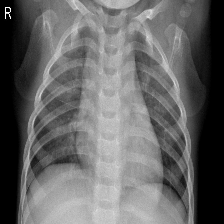


Image5: NORMAL2-IM-0033-0001.jpeg
True: Normal
Predicted: Normal


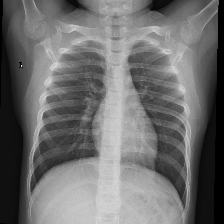


Image6: NORMAL2-IM-0277-0001.jpeg
True: Normal
Predicted: Pneumonia


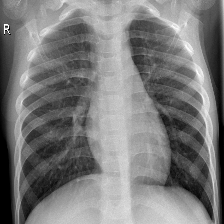


Image7: NORMAL2-IM-0335-0001.jpeg
True: Normal
Predicted: Pneumonia


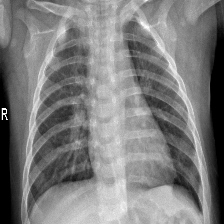


Image8: IM-0022-0001.jpeg
True: Normal
Predicted: Normal


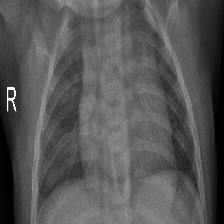


Image9: person87_bacteria_434.jpeg
True: Pneumonia
Predicted: Pneumonia


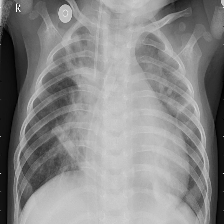

In [ ]:
display_prediction_samples(1, model_1_best, true, predicted)

**Plotting The Accuracies and Losses of Model 1**

Model History unavailable in current session. Loading from CSV: 
Available Files: 
1) Model_2_training_03-08-2020_(07_22)_MAX.csv
2) Model_1_training_11-08-2020_(08_11)_AVG.csv
3) Model_1_training_03-08-2020_(04_39)_MAX.csv
4) Model_2_training_11-08-2020_(19_16)_AVG.csv
5) Model_3_training_11-08-2020_(06_20)_AVG.csv
6) Model_3_training_03-08-2020_(20_26)_MAX.csv
Input File name: 
Model_1_training_03-08-2020_(04_39)_MAX.csv


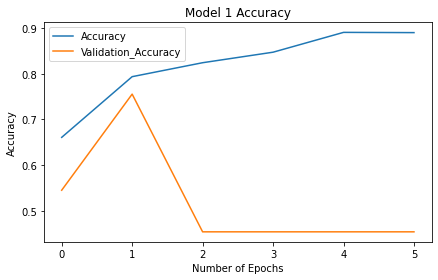

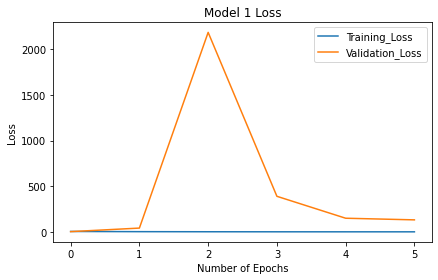

In [ ]:
try:
  modelHistory_tocsv(model_1_history, 1)
  plot_accuracy(model_1_history, 1)
  plot_loss(model_1_history, 1) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_1_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_1_history_csv, 1, csv=True)
  plot_loss(model_1_history_csv, 1, csv=True) 

**Confusion Matrix**

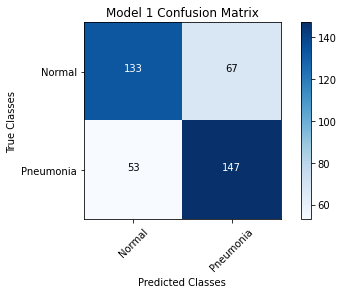

In [ ]:
conf_matrix = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix, classes=['Normal', 'Pneumonia'], model_num=1)

## **Model 1 (Average pooling strategy)**


**Model 1 Creation**


> **Using Average Pooling Strategy**




In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm (0.001)
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
"""
Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
 - The default value is 0.9 however, this value would be best configured with a decay rate of: 
    -> learning_rate(lr) / number of iterations (epochs) 
"""
model_1 = get_model(mode="avg")
model_1.compile(optimizer=optimizer_config, loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 216, 32)      7808      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      82976     
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 216, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 216, 216, 32)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 108, 108, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      1

In [ ]:
print("Training Model 1: ")
create_model_directory(1, mode="avg")
callbacks = get_callbacks(1, mode="avg")
model_1_history = model_1.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=num_epochs, validation_data=val_datagen, validation_steps=len(val_datagen), callbacks=callbacks)

Training Model 1: 
Path does not exist, creating directory at path: /content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 1/
Returning_early stop, best_checkpoint and reduce_lr
Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 4.4547 - accuracy: 0.6717 
Epoch 00001: val_accuracy improved from -inf to 0.54545, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 1/01-epochs-0.545-val_acc-32.108-val_loss.hdf5
59/59 [==============================] - 1878s 32s/step - loss: 4.4547 - accuracy: 0.6717 - val_loss: 32.1080 - val_accuracy: 0.5455
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 2.3160 - accuracy: 0.7781
Epoch 00002: val_accuracy did not improve from 0.54545
59/59 [==============================] - 72s 1s/step - loss: 2.3160 - accuracy: 0.7781 - val_loss: 3308.8684 - val_accuracy: 0.5455
Epoch 3/25
59/59 [==============================] - ETA: 0s - loss: 1.2723 - accuracy: 0.8102
Epoc

In [ ]:
model_1_directory = get_model_directory(1, mode="avg")
model_1_best_path = get_best_model_name(model_1_directory)
model_1_best = load_model(model_1_best_path)
true, predicted = print_results(1, model_1_best)

['01-epochs-0.545-val_acc-32.108-val_loss.hdf5']
Evaluating Model 1
1/1 [==============================] - 0s 6ms/step - loss: 3.3121 - accuracy: 0.5025
Making predictions using Model 1
1/1 [==============================] - 1s 1s/step
-----------------------------------
     Printing Model 1 Results
-----------------------------------
 -> Loss: 3.31  
 -> Accuracy: 50.25%
 -> Precision: 100.00%
 -> Recall: 0.50%
 -> F1-Score: 1.00%
 -> AUROC-Score: 0.5025


displaying images
Image0: person81_bacteria_398.jpeg
True: Pneumonia
Predicted: Pneumonia


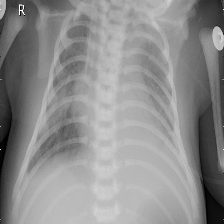


Image1: person3_virus_16.jpeg
True: Pneumonia
Predicted: Pneumonia


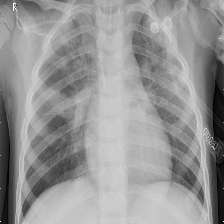


Image2: person29_virus_64.jpeg
True: Pneumonia
Predicted: Pneumonia


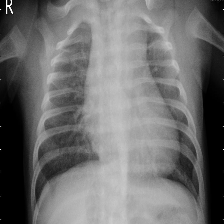


Image3: NORMAL2-IM-0280-0001.jpeg
True: Normal
Predicted: Pneumonia


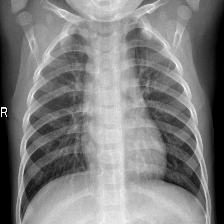


Image4: person38_virus_83.jpeg
True: Pneumonia
Predicted: Pneumonia


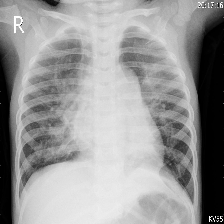


Image5: IM-0041-0001.jpeg
True: Normal
Predicted: Pneumonia


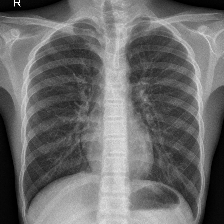


Image6: IM-0089-0001.jpeg
True: Normal
Predicted: Pneumonia


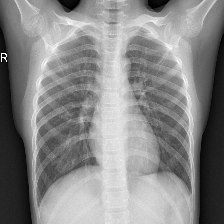


Image7: person108_bacteria_506.jpeg
True: Pneumonia
Predicted: Pneumonia


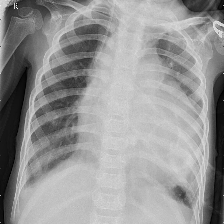


Image8: person41_virus_88.jpeg
True: Pneumonia
Predicted: Pneumonia


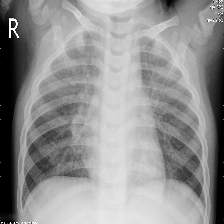


Image9: NORMAL2-IM-0276-0001.jpeg
True: Normal
Predicted: Pneumonia


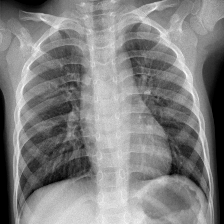

In [ ]:
display_prediction_samples(1, model_1_best, true, predicted)

Path does not exist. Creating new directory at path: /content/gdrive/My Drive/Colab Notebooks/logs/Model_1_training_11-08-2020_(08_11).csv
Creating Directory
[Errno 17] File exists: '/content/gdrive/My Drive/Colab Notebooks/logs/'


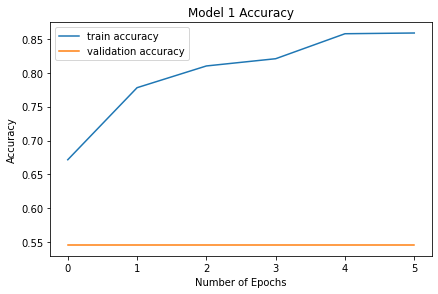

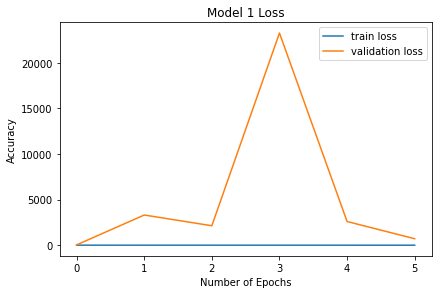

In [ ]:
try:
  modelHistory_tocsv(model_1_history, 1, mode="avg")
  plot_accuracy(model_1_history, 1)
  plot_loss(model_1_history, 1) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_1_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_1_history_csv, 1, csv=True)
  plot_loss(model_1_history_csv, 1, csv=True) 

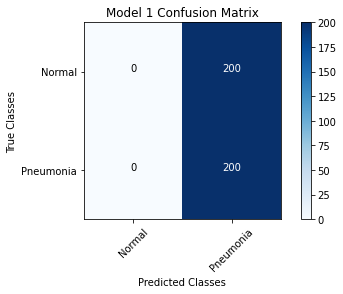

In [ ]:
conf_matrix = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix, classes=['Normal', 'Pneumonia'], model_num=1)

## **Model 2 (Max pooling strategy)**

**Model Creation**

In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
""" SAME AS IN MODEL 1
Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
 - The default value is 0.9 however, this value would be best configured with a decay rate of: 
    -> learning_rate(lr) / number of iterations (epochs) 
"""
model_2 = get_model()
model_2.compile(optimizer=optimizer_config, loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 216, 216, 32)      7808      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 216, 216, 32)      82976     
_________________________________________________________________
batch_normalization_11 (Batc (None, 216, 216, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 108, 108, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 108, 108, 64)     

**Training Model 2**

In [ ]:
clear_model_directory(2)

Clearing all files at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/
Removed file at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/01-epochs-0.556-val_acc-0.141-val_loss.hdf5
Removed file at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/02-epochs-0.632-val_acc-0.239-val_loss.hdf5
Removed file at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/04-epochs-0.728-val_acc-0.217-val_loss.hdf5
Removed file at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/05-epochs-0.893-val_acc-0.337-val_loss.hdf5
Removed file at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/06-epochs-0.906-val_acc-0.285-val_loss.hdf5


In [ ]:
train_datagen, test_datagen, val_datagen = get_img_datagen(2, batch_size, target_size)

Found 1870 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [ ]:
print("Training Model 2: ")
weights = get_class_weights(train_datagen.classes)
create_model_directory(2)
callbacks = get_callbacks(2)
model_2_history = model_2.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=25, validation_data=val_datagen, validation_steps=len(val_datagen), class_weight=weights, callbacks=callbacks)

Training Model 2: 
Path Exists already: /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/
Returning_early stop, best_checkpoint and reduce_lr
Epoch 1/25
59/59 [==============================] - 155s 3s/step - loss: 0.3589 - accuracy: 0.8791 - val_loss: 0.2972 - val_accuracy: 0.7836

Epoch 00001: val_accuracy improved from -inf to 0.78364, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/01-epochs-0.784-val_acc-0.297-val_loss.hdf5
Epoch 2/25
59/59 [==============================] - 151s 3s/step - loss: 0.3237 - accuracy: 0.8925 - val_loss: 0.3591 - val_accuracy: 0.8873

Epoch 00002: val_accuracy improved from 0.78364 to 0.88727, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 2/02-epochs-0.887-val_acc-0.359-val_loss.hdf5
Epoch 3/25
59/59 [==============================] - 152s 3s/step - loss: 0.3431 - accuracy: 0.8834 - val_loss: 0.3422 - val_accuracy: 0.8991

Epoch 00003: val_accuracy improved from 0.88727 to 0.89909, saving model to 

Model History unavailable in current session. Loading from CSV: 
Available Files: 
1) Model_1_training_03-08-2020_(04_39).csv
2) Model_2_training_03-08-2020_(07_22).csv
Input File name: 
Model_2_training_03-08-2020_(07_22).csv


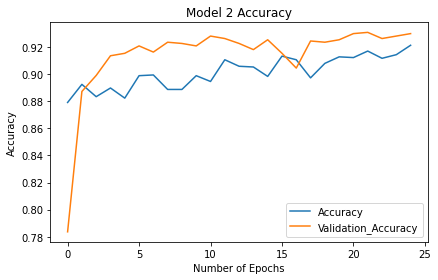

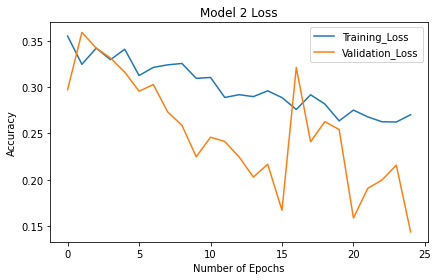

In [ ]:
try:
  modelHistory_tocsv(model_2_history, 2)
  plot_accuracy(model_2_history, 2)
  plot_loss(model_2_history, 2) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_2_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_2_history_csv, 2, csv=True)
  plot_loss(model_2_history_csv, 2, csv=True) 

**Testing the best version of Model 2**

In [ ]:
model_2_directory = get_model_directory(2, mode="max")
model_2_best_path = get_best_model_name(model_2_directory)
print(model_2_best_path)
model_2_best = load_model(model_2_best_path)
true, predicted = print_results(2, model_2_best)

['01-epochs-0.784-val_acc-0.297-val_loss.hdf5', '02-epochs-0.887-val_acc-0.359-val_loss.hdf5', '03-epochs-0.899-val_acc-0.342-val_loss.hdf5', '04-epochs-0.914-val_acc-0.331-val_loss.hdf5', '05-epochs-0.915-val_acc-0.316-val_loss.hdf5', '06-epochs-0.921-val_acc-0.296-val_loss.hdf5', '08-epochs-0.924-val_acc-0.273-val_loss.hdf5', '11-epochs-0.928-val_acc-0.246-val_loss.hdf5', '21-epochs-0.930-val_acc-0.159-val_loss.hdf5', '22-epochs-0.931-val_acc-0.191-val_loss.hdf5']
/content/gdrive/My Drive/Colab Notebooks/Models/Max Pooling Strategy/Model 2/22-epochs-0.931-val_acc-0.191-val_loss.hdf5
Evaluating Model 2
1/1 [==============================] - 0s 4ms/step - loss: 0.5062 - accuracy: 0.8125
Making predictions using Model 2
1/1 [==============================] - 1s 1s/step
-----------------------------------
     Printing Model 2 Results
-----------------------------------
 -> Loss: 0.51  
 -> Accuracy: 81.25%
 -> Precision: 74.32%
 -> Recall: 95.50%
 -> F1-Score: 83.59%
 -> AUROC-Score: 0.

displaying images
Image0: IM-0043-0001.jpeg
True: Normal
Predicted: Pneumonia


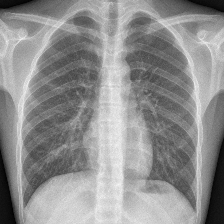


Image1: NORMAL2-IM-0221-0001.jpeg
True: Normal
Predicted: Normal


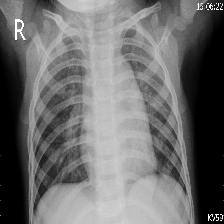


Image2: person83_bacteria_410.jpeg
True: Pneumonia
Predicted: Pneumonia


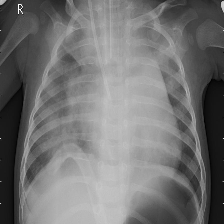


Image3: person45_virus_95.jpeg
True: Pneumonia
Predicted: Pneumonia


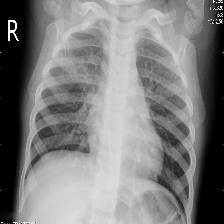


Image4: IM-0065-0001.jpeg
True: Normal
Predicted: Normal


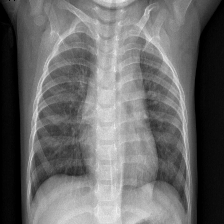


Image5: person51_virus_105.jpeg
True: Pneumonia
Predicted: Pneumonia


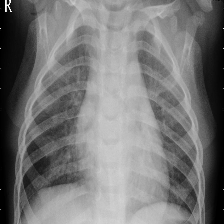


Image6: person3_virus_16.jpeg
True: Pneumonia
Predicted: Pneumonia


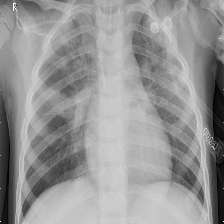


Image7: person96_bacteria_464.jpeg
True: Pneumonia
Predicted: Pneumonia


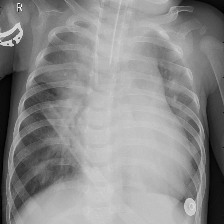


Image8: person111_bacteria_535.jpeg
True: Pneumonia
Predicted: Pneumonia


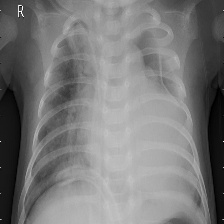


Image9: NORMAL2-IM-0222-0001.jpeg
True: Normal
Predicted: Pneumonia


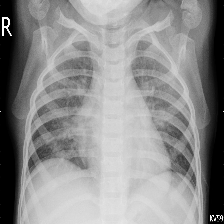

In [ ]:
display_prediction_samples(1, model_1_best, true, predicted)

**Confusion Matrix**

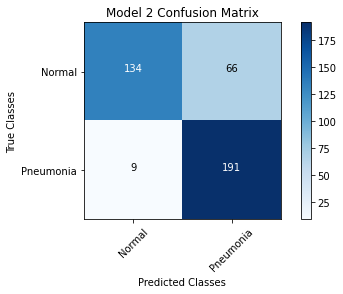

In [ ]:
conf_matrix2 = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix2, classes=['Normal', 'Pneumonia'], model_num=2)

## **Model 2 (Average pooling strategy)**

In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
""" SAME AS IN MODEL 1
Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
 - The default value is 0.9 however, this value would be best configured with a decay rate of: 
    -> learning_rate(lr) / number of iterations (epochs) 
"""
model_2 = get_model(mode="avg")
model_2.compile(optimizer=optimizer_config, loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 216, 32)      7808      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      82976     
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 216, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 216, 216, 32)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 108, 108, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      1

In [ ]:
print("Training Model 2: ")
weights = get_class_weights(train_datagen.classes)
create_model_directory(2, mode="avg")
callbacks = get_callbacks(2, mode="avg")
model_2_history = model_2.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=25, validation_data=val_datagen, validation_steps=len(val_datagen), class_weight=weights, callbacks=callbacks)

Training Model 2: 
Path Exists already: /content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 2/
Returning_early stop, best_checkpoint and reduce_lr
Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 4.5550 - accuracy: 0.6556 
Epoch 00001: val_accuracy improved from -inf to 0.54636, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 2/01-epochs-0.546-val_acc-5.620-val_loss.hdf5
59/59 [==============================] - 1318s 22s/step - loss: 4.5550 - accuracy: 0.6556 - val_loss: 5.6196 - val_accuracy: 0.5464
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 2.4688 - accuracy: 0.7524
Epoch 00002: val_accuracy improved from 0.54636 to 0.67818, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 2/02-epochs-0.678-val_acc-2.994-val_loss.hdf5
59/59 [==============================] - 164s 3s/step - loss: 2.4688 - accuracy: 0.7524 - val_loss: 2.9942 - val_accur

Path does not exist. Creating new directory at path: /content/gdrive/My Drive/Colab Notebooks/logs/Model_2_training_11-08-2020_(19_16).csv
Creating Directory
[Errno 17] File exists: '/content/gdrive/My Drive/Colab Notebooks/logs/'


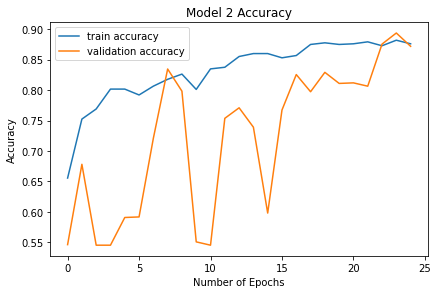

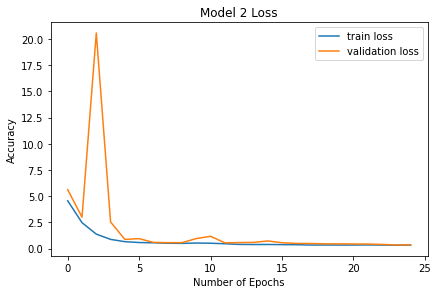

In [ ]:
try:
  modelHistory_tocsv(model_2_history, 2, mode="avg")
  plot_accuracy(model_2_history, 2)
  plot_loss(model_2_history, 2) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_2_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_2_history_csv, 2, csv=True)
  plot_loss(model_2_history_csv, 2, csv=True) 

In [ ]:
model_2_directory = get_model_directory(2, mode="avg")
model_2_best_path = get_best_model_name(model_2_directory)
print(model_2_best_path)
model_2_best = load_model(model_2_best_path)
true, predicted = print_results(2, model_2_best)

['.ipynb_checkpoints', '01-epochs-0.546-val_acc-5.620-val_loss.hdf5', '02-epochs-0.678-val_acc-2.994-val_loss.hdf5', '07-epochs-0.721-val_acc-0.588-val_loss.hdf5', '08-epochs-0.835-val_acc-0.560-val_loss.hdf5', '23-epochs-0.875-val_acc-0.394-val_loss.hdf5', '24-epochs-0.894-val_acc-0.337-val_loss.hdf5']
/content/gdrive/My Drive/Colab Notebooks/Models/Avg Pooling Strategy/Model 2/24-epochs-0.894-val_acc-0.337-val_loss.hdf5
Evaluating Model 2
1/1 [==============================] - 0s 7ms/step - loss: 0.4879 - accuracy: 0.8125
Making predictions using Model 2
1/1 [==============================] - 1s 1s/step
-----------------------------------
     Printing Model 2 Results
-----------------------------------
 -> Loss: 0.49  
 -> Accuracy: 81.25%
 -> Precision: 79.62%
 -> Recall: 84.00%
 -> F1-Score: 81.75%
 -> AUROC-Score: 0.8125


displaying images
Image0: NORMAL2-IM-0219-0001.jpeg
True: Normal
Predicted: Normal


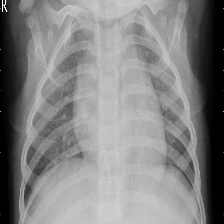


Image1: person1_virus_12.jpeg
True: Pneumonia
Predicted: Pneumonia


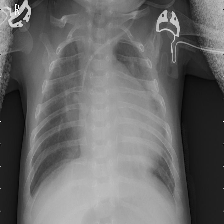


Image2: person111_bacteria_534.jpeg
True: Pneumonia
Predicted: Pneumonia


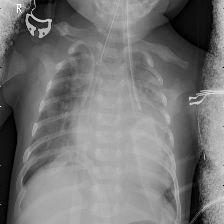


Image3: NORMAL2-IM-0233-0001.jpeg
True: Normal
Predicted: Normal


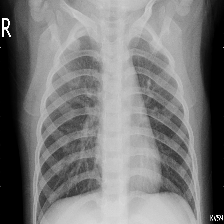


Image4: person85_bacteria_423.jpeg
True: Pneumonia
Predicted: Pneumonia


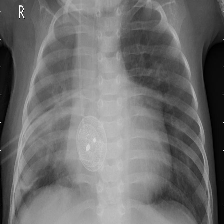


Image5: NORMAL2-IM-0267-0001.jpeg
True: Normal
Predicted: Pneumonia


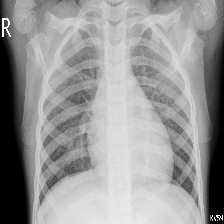


Image6: NORMAL2-IM-0110-0001.jpeg
True: Normal
Predicted: Normal


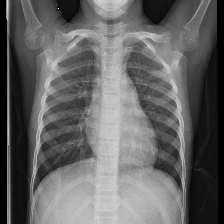


Image7: person44_virus_94.jpeg
True: Pneumonia
Predicted: Pneumonia


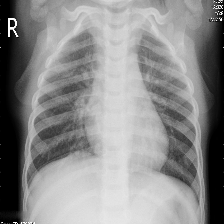


Image8: NORMAL2-IM-0278-0001.jpeg
True: Normal
Predicted: Pneumonia


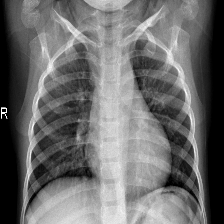


Image9: person111_bacteria_533.jpeg
True: Pneumonia
Predicted: Pneumonia


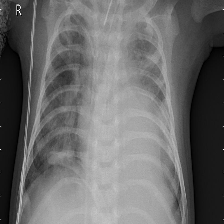

In [ ]:
display_prediction_samples(1, model_1_best, true, predicted)

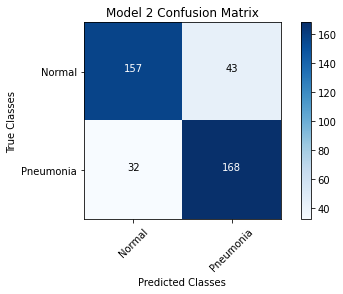

In [ ]:
conf_matrix2 = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix2, classes=['Normal', 'Pneumonia'], model_num=2)

**Evaluation of Model 2 Results**

## **Model 3 (Max Pooling Strategy)**

In [ ]:
model_3_base = InceptionV3(include_top=False, weights='imagenet',input_tensor=Input(shape=(224,224,3)))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
# SAME AS IN MODEL 1
# Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
#   - The default value is 0.9 however, this value would be best configured with a decay rate of: 
#       -> learning_rate(lr) / number of iterations (epochs) 

In [ ]:
model_3_head = model_3_base.output
model_3_head = BatchNormalization()(model_3_head)
model_3_head = Activation('relu')(model_3_head)
model_3_head = MaxPooling2D(pool_size=(4,4))(model_3_head)
model_3_head = Flatten()(model_3_head)
model_3_head = Dense(units=128, activation='relu')(model_3_head)
model_3_head = Dropout(0.5)(model_3_head)
model_3_head = Dense(units=128, activation='relu')(model_3_head)
model_3_head = Dropout(0.2)(model_3_head)
model_3_head_output = Dense(2, activation='softmax')(model_3_head)
model_3 = Model(inputs=model_3_base.input, outputs=model_3_head_output)
model_3.compile(optimizer=optimizer_config,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
train_datagen, test_datagen, val_datagen = get_img_datagen(3, batch_size, target_size, rescale_factor)

Found 1870 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [ ]:
for layer in model_3_base.layers:
  layer.trainable = False

In [ ]:
create_model_directory(3)
callbacks = get_callbacks(3)
model_3_history = model_3.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=25, validation_data=val_datagen, validation_steps=len(val_datagen), callbacks=callbacks)

Path does not exist, creating directory at path: /content/gdrive/My Drive/Colab Notebooks/Models/Max Pooling Strategy/Model 3/
Returning early_stop, best_checkpoint, reduce_lr and custom_callback
Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 0.7784 - accuracy: 0.7631
Epoch 00001: val_accuracy improved from -inf to 0.45455, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Max Pooling Strategy/Model 3/01-epochs-0.455-val_acc-330712.312-val_loss.hdf5
59/59 [==============================] - 197s 3s/step - loss: 0.7784 - accuracy: 0.7631 - val_loss: 330712.3125 - val_accuracy: 0.4545
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.8123
Epoch 00002: val_accuracy improved from 0.45455 to 0.54545, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Max Pooling Strategy/Model 3/02-epochs-0.545-val_acc-5179883.500-val_loss.hdf5
59/59 [==============================] - 167s 3s/step - loss: 0.8142 - accuracy

Path does not exist. Creating new directory at path: /content/gdrive/My Drive/Colab Notebooks/logs/Model_3_training_11-08-2020_(20_26).csv
Creating Directory
[Errno 17] File exists: '/content/gdrive/My Drive/Colab Notebooks/logs/'


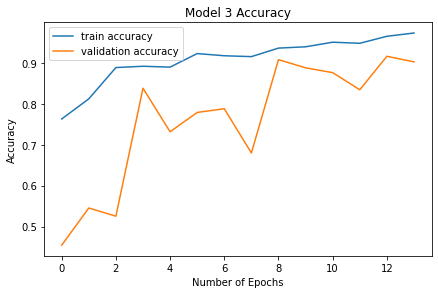

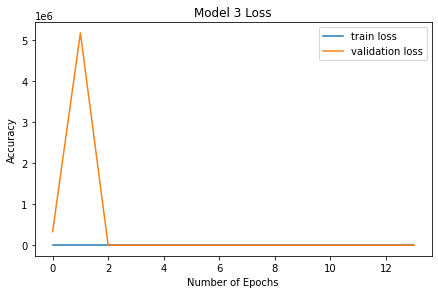

In [ ]:
try:
  modelHistory_tocsv(model_3_history, 3)
  plot_accuracy(model_3_history, 3)
  plot_loss(model_3_history, 3) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_3_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_3_history_csv, 3, csv=True)
  plot_loss(model_3_history_csv, 3, csv=True) 

In [20]:
model_3_directory = get_model_directory(3)
model_3_best_path = get_best_model_name(model_3_directory)
model_3_best = load_model(model_3_best_path)
true, predicted = print_results(3, model_3_best)

['01-epochs-0.455-val_acc-330712.312-val_loss.hdf5', '02-epochs-0.545-val_acc-5179883.500-val_loss.hdf5', '04-epochs-0.838-val_acc-0.592-val_loss.hdf5', '09-epochs-0.908-val_acc-0.221-val_loss.hdf5', '13-epochs-0.916-val_acc-0.225-val_loss.hdf5']
Evaluating Model 3
1/1 [==============================] - 0s 3ms/step - loss: 0.2894 - accuracy: 0.8875
Making predictions using Model 3
1/1 [==============================] - 1s 701ms/step
-----------------------------------
     Printing Model 3 Results
-----------------------------------
 -> Loss: 0.29  
 -> Accuracy: 88.75%
 -> Precision: 88.18%
 -> Recall: 89.50%
 -> F1-Score: 88.83%
 -> AUROC-Score: 0.8875


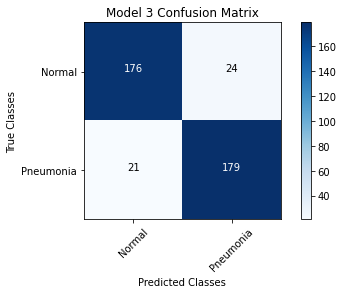

In [21]:
conf_matrix3 = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix3, classes=['Normal', 'Pneumonia'], model_num=3)

## **Model 3 (Average Pooling Strategy)**

In [ ]:
model_3_base = InceptionV3(include_top=False, weights='imagenet',input_tensor=Input(shape=(224,224,3)))
# model_3_base.summary()

In [ ]:
num_epochs = 25 # Using a default epoch number of 25
lr = 1e-3 # Default value for the optimiser which implements the Adam algorithm
optimizer_config = Adam(learning_rate=lr, beta_1=lr/num_epochs) 
# SAME AS IN MODEL 1
# Beta_1: This variable denotes the exponential decay rate for the first moment estimate (parameter estimation). 
#   - The default value is 0.9 however, this value would be best configured with a decay rate of: 
#       -> learning_rate(lr) / number of iterations (epochs) 


In [ ]:
model_3_head = model_3_base.output
model_3_head = BatchNormalization()(model_3_head)
model_3_head = Activation('relu')(model_3_head)
model_3_head = AveragePooling2D(pool_size=(4,4))(model_3_head)
model_3_head = Flatten()(model_3_head)
model_3_head = Dense(units=128, activation='relu')(model_3_head)
model_3_head = Dropout(0.5)(model_3_head)
model_3_head = Dense(units=128, activation='relu')(model_3_head)
model_3_head = Dropout(0.2)(model_3_head)
model_3_head_output = Dense(2, activation='softmax')(model_3_head)
model_3 = Model(inputs=model_3_base.input, outputs=model_3_head_output)
model_3.compile(optimizer=optimizer_config,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_datagen, test_datagen, val_datagen = get_img_datagen(3, batch_size, target_size, rescale_factor)

Found 1870 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [ ]:
for layer in model_3_base.layers:
  layer.trainable = False

In [ ]:
create_model_directory(3, mode="avg")
callbacks = get_callbacks(3, mode="avg")
model_3_history = model_3.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=25, validation_data=val_datagen, validation_steps=len(val_datagen), callbacks=callbacks)

**Training the Last layer of Model 3**

In [ ]:
create_model_directory(3, mode="avg")
callbacks = get_callbacks(3, mode="avg")
model_3_history = model_3.fit(train_datagen, steps_per_epoch=len(train_datagen), epochs=25, validation_data=val_datagen, validation_steps=len(val_datagen), callbacks=callbacks)

Path does not exist, creating directory at path: /content/gdrive/My Drive/Colab Notebooks/Models/Model 3/
Returning early_stop, best_checkpoint, reduce_lr and custom_callback
Epoch 1/25
59/59 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8070 
Epoch 00001: val_accuracy improved from -inf to 0.59000, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 3/01-epochs-0.590-val_acc-3.657-val_loss.hdf5
59/59 [==============================] - 1176s 20s/step - loss: 0.4792 - accuracy: 0.8070 - val_loss: 3.6572 - val_accuracy: 0.5900
Epoch 2/25
59/59 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8952
Epoch 00002: val_accuracy improved from 0.59000 to 0.69091, saving model to /content/gdrive/My Drive/Colab Notebooks/Models/Model 3/02-epochs-0.691-val_acc-3.828-val_loss.hdf5
59/59 [==============================] - 203s 3s/step - loss: 0.2914 - accuracy: 0.8952 - val_loss: 3.8282 - val_accuracy: 0.6909
Epoch 3/25
59/59 [=======

Path does not exist. Creating new directory at path: /content/gdrive/My Drive/Colab Notebooks/logs/Model_3_training_05-08-2020_(06_20).csv
Creating Directory
[Errno 17] File exists: '/content/gdrive/My Drive/Colab Notebooks/logs/'


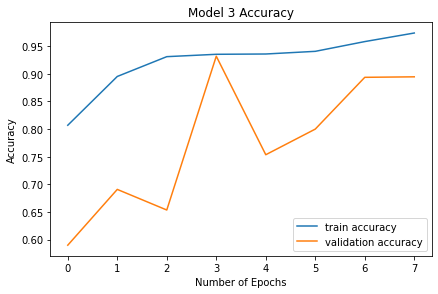

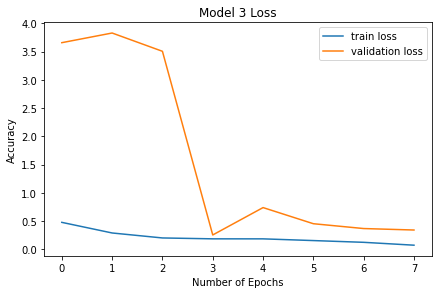

In [ ]:
try:
  modelHistory_tocsv(model_3_history, 3)
  plot_accuracy(model_3_history, 3)
  plot_loss(model_3_history, 3) 
except (NameError, AttributeError) as e:
  print("Model History unavailable in current session. Loading from CSV: ")
  model_3_history_csv = load_df_from_csv(csv_directory)
  plot_accuracy(model_3_history_csv, 3, csv=True)
  plot_loss(model_3_history_csv, 3, csv=True) 

In [ ]:
model_3_directory = get_model_directory(3, mode="avg")
model_3_best_path = get_best_model_name(model_3_directory)
model_3_best = load_model(model_3_best_path)
true, predicted = print_results(3, model_3_best)

['01-epochs-0.590-val_acc-3.657-val_loss.hdf5', '02-epochs-0.691-val_acc-3.828-val_loss.hdf5', '04-epochs-0.932-val_acc-0.256-val_loss.hdf5']
Evaluating Model 3
1/1 [==============================] - 0s 7ms/step - loss: 0.4022 - accuracy: 0.8375
Making predictions using Model 3
1/1 [==============================] - 2s 2s/step
-----------------------------------
     Printing Model 3 Results
-----------------------------------
 -> Loss: 0.40  
 -> Accuracy: 83.75%
 -> Precision: 79.22%
 -> Recall: 91.50%
 -> F1-Score: 84.92%
 -> AUROC-Score: 0.8375


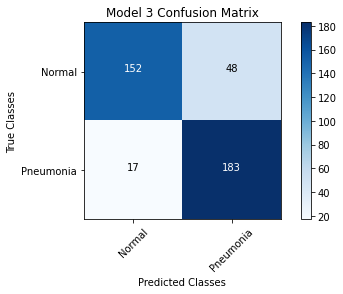

In [ ]:
conf_matrix3 = confusion_matrix(y_true=true, y_pred = predicted)
plot_conf_matrix(conf_matrix3, classes=['Normal', 'Pneumonia'], model_num=3)

# **Plotting the training loss and accuracy of all models**

Text(0.5, 0, 'Number of Epochs')

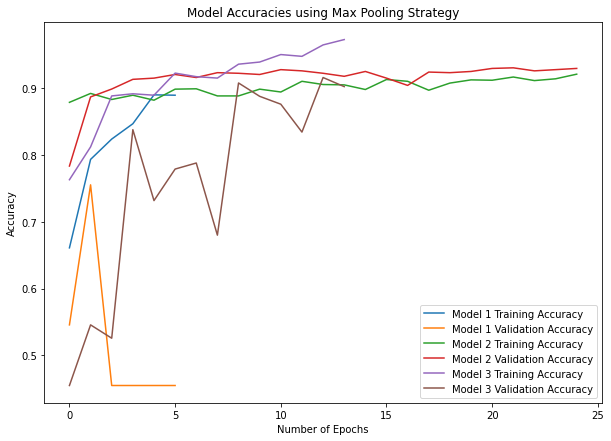

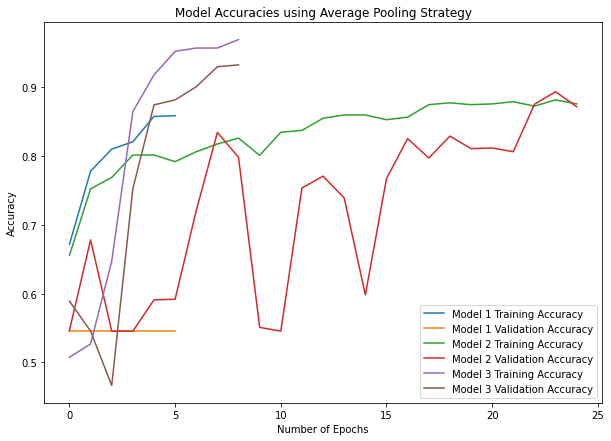

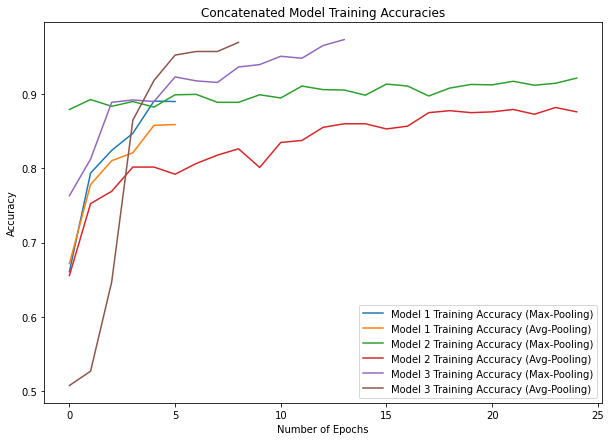

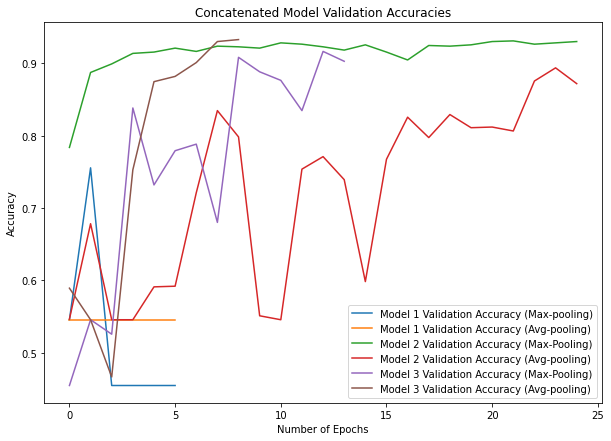

In [10]:
for r, d, files in os.walk(csv_directory):
    for filename in files: 
      if "1" in filename.split("_"):
        # print("Model 1: {} \n".format(filename))
        file_path = csv_directory + filename
        if "MAX.csv" in filename.split("_"):
          model_1_history = pd.read_csv(file_path, sep=',', index_col=0)
        else: 
          model_1_history_avg = pd.read_csv(file_path, sep=',', index_col=0)
      elif "2" in filename.split("_"):
        # print("Model 2: {} \n".format(filename))
        file_path = csv_directory + filename
        if "MAX.csv" in filename.split("_"):
          model_2_history = pd.read_csv(file_path, sep=',', index_col=0)
        else: 
          model_2_history_avg = pd.read_csv(file_path, sep=',', index_col=0)
      else: 
        # print("Model 3: {} \n".format(filename))
        file_path = csv_directory + filename
        if "MAX.csv" in filename.split("_"):
          model_3_history = pd.read_csv(file_path, sep=',', index_col=0)
        else: 
          model_3_history_avg = pd.read_csv(file_path, sep=',', index_col=0)


ax = model_1_history.plot(x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 1 Training Accuracy", "Model 1 Validation Accuracy"], figsize=(10,7))
model_2_history.plot(ax=ax, x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 2 Training Accuracy", "Model 2 Validation Accuracy"])
model_3_history.plot(ax=ax, x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 3 Training Accuracy", "Model 3 Validation Accuracy"])
plt.title(label="Model Accuracies using Max Pooling Strategy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")


ax = model_1_history_avg.plot(x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 1 Training Accuracy", "Model 1 Validation Accuracy"], figsize=(10,7))
model_2_history_avg.plot(ax=ax, x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 2 Training Accuracy", "Model 2 Validation Accuracy"])
model_3_history_avg.plot(ax=ax, x="Epochs", y=["Accuracy", "Validation_Accuracy"], label=["Model 3 Training Accuracy", "Model 3 Validation Accuracy"])
plt.title(label="Model Accuracies using Average Pooling Strategy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")

ax = model_1_history.plot(x="Epochs", y=["Accuracy"], label=["Model 1 Training Accuracy (Max-Pooling)"], figsize=(10,7))
model_1_history_avg.plot(ax=ax, x="Epochs", y=["Accuracy"], label=["Model 1 Training Accuracy (Avg-Pooling)"])
model_2_history.plot(ax=ax, x="Epochs", y=["Accuracy"], label=["Model 2 Training Accuracy (Max-Pooling)"])
model_2_history_avg.plot(ax=ax, x="Epochs", y=["Accuracy"], label=["Model 2 Training Accuracy (Avg-Pooling)"])
model_3_history.plot(ax=ax, x="Epochs", y=["Accuracy"], label=["Model 3 Training Accuracy (Max-Pooling)"])
model_3_history_avg.plot(ax=ax, x="Epochs", y=["Accuracy"], label=["Model 3 Training Accuracy (Avg-Pooling)"])
plt.title(label="Concatenated Model Training Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")

ax = model_1_history.plot(x="Epochs", y=["Validation_Accuracy"], label=["Model 1 Validation Accuracy (Max-pooling)"], figsize=(10,7))
model_1_history_avg.plot(ax=ax, x="Epochs", y=["Validation_Accuracy"], label=["Model 1 Validation Accuracy (Avg-pooling)"])
model_2_history.plot(ax=ax, x="Epochs", y=["Validation_Accuracy"], label=["Model 2 Validation Accuracy (Max-Pooling)"])
model_2_history_avg.plot(ax=ax, x="Epochs", y=["Validation_Accuracy"], label=["Model 2 Validation Accuracy (Avg-pooling)"])
model_3_history.plot(ax=ax, x="Epochs", y=["Validation_Accuracy"], label=["Model 3 Validation Accuracy (Max-Pooling)"])
model_3_history_avg.plot(ax=ax, x="Epochs", y=["Validation_Accuracy"], label=["Model 3 Validation Accuracy (Avg-pooling)"])
plt.title(label="Concatenated Model Validation Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")